In [17]:
# Implement batch gradient descent with early stopping for softmax regression without using scikit-Learn, only numpy.
# Use iris dataset

In [18]:
!python --version

Python 3.12.4


In [47]:
import numpy as np
from sklearn.datasets import load_iris
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [10]:
iris = load_iris()
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)

X = iris_df[["petal length (cm)", "petal width (cm)"]].values
y = iris.target

In [14]:
print(X[:5])

[[1.4 0.2]
 [1.4 0.2]
 [1.3 0.2]
 [1.5 0.2]
 [1.4 0.2]]


In [11]:
X_with_bias = np.c_[np.ones(len(X)), X]

In [15]:
print(X_with_bias[:5])

[[1.  1.4 0.2]
 [1.  1.4 0.2]
 [1.  1.3 0.2]
 [1.  1.5 0.2]
 [1.  1.4 0.2]]


We add a bias at the first columns to permit the model to shift on the y axis

Now we'll do a train test split manually


In [16]:
test_ratio = 0.2
validation_ratio = 0.2
total_size = len(X_with_bias)

test_size = int(total_size * test_ratio)
validation_size = int(total_size * validation_ratio)
train_size = int(total_size - test_size - validation_size) 

np.random.seed(42)
rnd_indices = np.random.permutation(total_size) # Random mix of indices to reach a better distribution

X_train = X_with_bias[rnd_indices[:train_size]]
y_train = y[rnd_indices[:train_size]]

X_valid = X_with_bias[rnd_indices[train_size:-test_size]] # -test_size because we want it from the end of the array
y_valid  = y[rnd_indices[train_size:-test_size]]

X_test = X_with_bias[rnd_indices[:-test_size]] # We get the last 0.2 of the array
y_test = y[rnd_indices[:-test_size]]

In [20]:
def to_one_hot(y):
    return np.diag(np.ones(y.max() + 1))[y] # Retruns a diagonal matrix with each class. y.max() + 1 gives the nb of classes (0 indexed) and [y] indexes for each label

In [21]:
# Test the function

y_train[:10] # train test split test for the 10th first values

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1])

In [22]:
to_one_hot(y_train[:10]) # We have a one hot encoding for each label

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]])

Target classes probabilities classes for training and test sets

In [23]:
Y_train_one_hot = to_one_hot(y_train)
Y_valid_one_hot = to_one_hot(y_valid)
Y_test_one_hot = to_one_hot(y_test)

In [25]:
# Scaling: center and scale
# X_centered = (X_i - mean(X)) / std (X)

mean = X_train[:, 1:].mean(axis=0)
std = X_train[:, 1:].std(axis=0)

X_train[:, 1:] = (X_train[:, 1:] - mean) / std
X_valid[:, 1:] = (X_valid[:, 1:] - mean) / std
X_test[:, 1:] = (X_test[:, 1:] - mean)/ std

Softmax function :

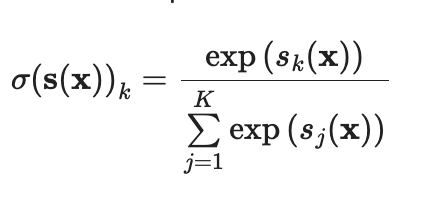

In [32]:
#logit(p) = log(p/(1-p))

# with p the probability of the event occuring


In [30]:
def softmax(logits):
    exps = np.exp(logits)
    exp_sums = exps.sum(axis=1, keepdims=True)
    return exps/ exp_sums

In [33]:
n_inputs = X_train.shape[1] # 3 (2 features and the bias)
n_outputs = len(np.unique(y_train)) # 3 bc 3 iris classes

Cost function

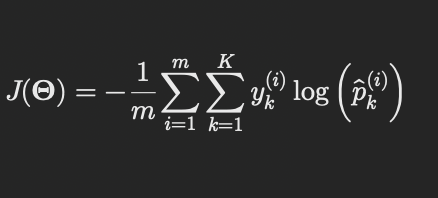

Gradient equation

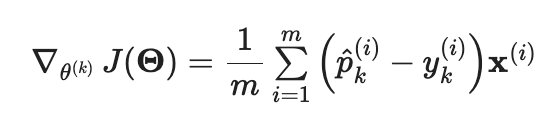

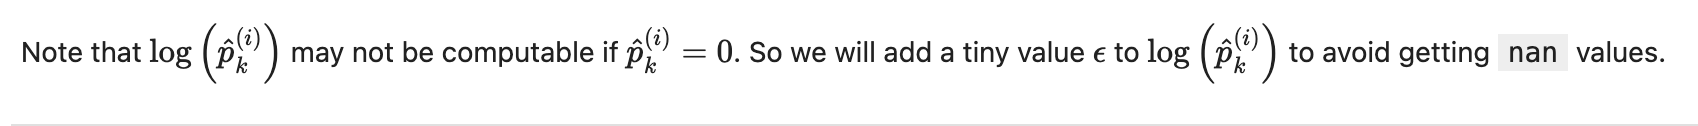

In [35]:
eta = 0.5           # Learning rate
n_epochs = 5001     # Number of training epochs
m = len(X_train)    # Number of training samples (columns)
epsilon = 1e-5      # Small constant to prevent log(0)

np.random.seed(42)
Theta = np.random.randn(n_inputs, n_outputs) # Random initialization of weights with a normal distribution

for epoch in range(n_epochs):
    logits = X_train @ Theta    # X_i . w_i compute the logits
    Y_proba = softmax(logits)   # Apply softmax function to get the probabilities   

    if epoch % 1000 == 0:   # each 1000 epoch
        Y_proba_valid = softmax(X_valid @ Theta)    # Validate on validation set
        xentropy_losses = -(Y_valid_one_hot * np.log(Y_proba_valid + epsilon))  # Compute cross-entropy loss
        print(epoch, xentropy_losses.sum(axis=1).mean())    # Print avg loss
    
    error = Y_proba - Y_train_one_hot   # Compute error between predicted and actual proba
    gradients = 1/m * X_train.T @ error # Compute the gradients
    Theta = Theta - eta * gradients     # Updating weights using gradient descent


0 3.7085808486476917
1000 0.1451936748083065
2000 0.13013095755040877
3000 0.12009639326384533
4000 0.11372961364786884
5000 0.11002459532472425


In [36]:
Theta

array([[ 0.41931626,  6.11112089, -5.52429876],
       [-6.53054533, -0.74608616,  8.33137102],
       [-5.28115784,  0.25152675,  6.90680425]])

In [37]:
# Compute predictions for validation set 

logits = X_valid @ Theta        # Compute the logits 
Y_proba = softmax(logits)       # Compute the probabilities
Y_predict = Y_proba.argmax(axis=1)  # Select the max proba for assign the occurence to a class

accuracy_score = (Y_predict == y_valid).mean()  # Compute accuracy score, boolean array mean
accuracy_score

0.9333333333333333

Let's add and L_2 regularization

In [40]:
eta = 0.5           # Learning rate
n_epochs = 5001     # Number of training epochs
m = len(X_train)    # Number of training samples (columns)
epsilon = 1e-5      # Small constant to prevent log(0)
alpha = 0.01        # Regularization parameter

np.random.seed(42)
Theta = np.random.randn(n_inputs, n_outputs) # Random initialization of weights with a normal distribution

for epoch in range(n_epochs):
    logits = X_train @ Theta    # X_i . w_i compute the logits
    Y_proba = softmax(logits)   # Apply softmax function to get the probabilities   

    if epoch % 1000 == 0:                                                       # each 1000 epoch
        Y_proba_valid = softmax(X_valid @ Theta)                                # Validate on validation set
        xentropy_losses = -(Y_valid_one_hot * np.log(Y_proba_valid + epsilon))  # Compute cross-entropy loss
        l2_loss = 1 / 2 * (Theta[1:] ** 2).sum()                                # l2 regularization loss
        total_loss = xentropy_losses.sum(axis=1).mean() + alpha * l2_loss       # Compute total loss
        print(epoch, total_loss.round(4))                                       # Print avg loss
    
    error = Y_proba - Y_train_one_hot                               # Compute error between predicted and actual proba
    gradients = 1/m * X_train.T @ error                             # Compute the gradients
    gradients += np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]] # Regularization of gradients
    Theta = Theta - eta * gradients                                 # Updating weights using gradient descent


# We divide by 2 and not by m for the regularization term for mathematical convenience, it avoid unecessary large coefficients


0 3.7372
1000 0.3259
2000 0.3259
3000 0.3259
4000 0.3259
5000 0.3259


In [41]:
# Compute predictions for validation set 

logits = X_valid @ Theta        # Compute the logits 
Y_proba = softmax(logits)       # Compute the probabilities
Y_predict = Y_proba.argmax(axis=1)  # Select the max proba for assign the occurence to a class

accuracy_score = (Y_predict == y_valid).mean()  # Compute accuracy score, boolean array mean
accuracy_score

0.9333333333333333

The regul didn't changed anything, try to fine-tune alpha

Implementing early stopping 


In [42]:
eta = 0.5
n_epochs = 50_001
m = len(X_train)
epsilon = 1e-5
C = 100  # regularization hyperparameter
best_loss = np.infty

np.random.seed(42)
Theta = np.random.randn(n_inputs, n_outputs)

for epoch in range(n_epochs):
    logits = X_train @ Theta
    Y_proba = softmax(logits)
    Y_proba_valid = softmax(X_valid @ Theta)
    xentropy_losses = -(Y_valid_one_hot * np.log(Y_proba_valid + epsilon))
    l2_loss = 1 / 2 * (Theta[1:] ** 2).sum()
    total_loss = xentropy_losses.sum(axis=1).mean() + 1 / C * l2_loss
    if epoch % 1000 == 0:
        print(epoch, total_loss.round(4))
    if total_loss < best_loss:
        best_loss = total_loss
    else:
        print(epoch - 1, best_loss.round(4))
        print(epoch, total_loss.round(4), "early stopping!")
        break
    error = Y_proba - Y_train_one_hot
    gradients = 1 / m * X_train.T @ error
    gradients += np.r_[np.zeros([1, n_outputs]), 1 / C * Theta[1:]]
    Theta = Theta - eta * gradients

0 3.7372
281 0.3256
282 0.3256 early stopping!


In [43]:
# Compute predictions for validation set 

logits = X_valid @ Theta        # Compute the logits 
Y_proba = softmax(logits)       # Compute the probabilities
Y_predict = Y_proba.argmax(axis=1)  # Select the max proba for assign the occurence to a class

accuracy_score = (Y_predict == y_valid).mean()  # Compute accuracy score, boolean array mean
accuracy_score

0.9333333333333333

It didn't changed anything but training time is quicker !

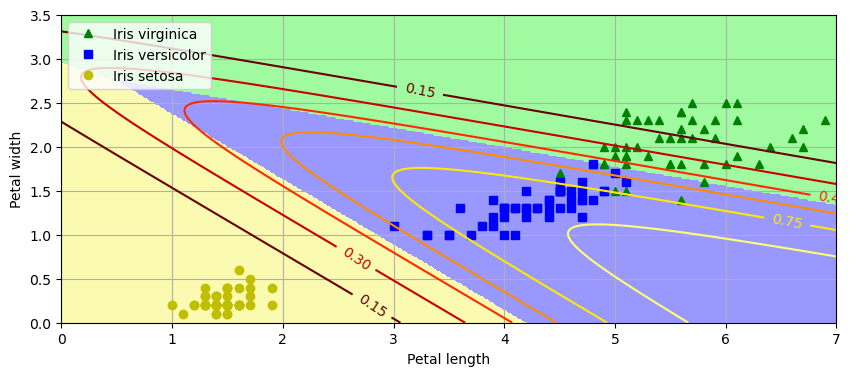

In [53]:
custom_cmap = mpl.colors.ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])

# Create a mesh grid for predictions
x0, x1 = np.meshgrid(np.linspace(0, 8, 500).reshape(-1, 1),
                     np.linspace(0, 3.5, 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()]   # ravel() return a flattened array = split matrices and write them in a single row

# Normalize the new data
mean = X.mean(axis=0)  # Compute mean
std = X.std(axis=0)    # Compute std deviation
X_new = (X_new - mean) / std
X_new_with_bias = np.c_[np.ones(len(X_new)), X_new]

# Compute logits and probabilities
logits = X_new_with_bias @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

# Reshape for plotting
zz1 = Y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

# Plotting
plt.figure(figsize=(10, 4))
plt.plot(X[y == 2, 0], X[y == 2, 1], "g^", label="Iris virginica")
plt.plot(X[y == 1, 0], X[y == 1, 1], "bs", label="Iris versicolor")
plt.plot(X[y == 0, 0], X[y == 0, 1], "yo", label="Iris setosa")

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap="hot")
plt.clabel(contour, inline=1)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper left")
plt.axis([0, 7, 0, 3.5])
plt.grid()
plt.show()

In [51]:
logits = X_test @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

accuracy_score = (y_predict == y_test).mean()
accuracy_score

0.9583333333333334